# Computationally Efficient Multiscale framework for determination of transport properties in Complex 3D Porous Media


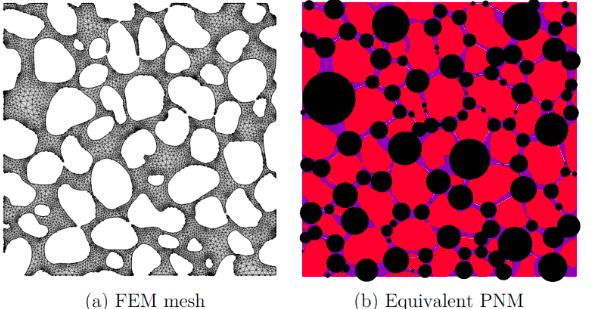

In [36]:
from IPython.display import Image
Image(filename='pnm.png')

## Code for computing relative permeability and relative diffusivity from tomography images 

In [37]:
import os
import imageio
import scipy as sp
import numpy as np
import openpnm as op
import openpnm.models.geometry as gmods
from openpnm.models import physics as pm
import porespy as ps
import matplotlib.pyplot as plt
np.set_printoptions(precision=4)
import openpnm.models as mods
np.random.seed(10)
%matplotlib inline

## Invasion simulation

## Computing relative permeability and diffusitivity from real tomography images

Liquid water distribution


To validate the distribution of liquid water in the domain, a one-to-one comparison was done between the experimental and numerical reconstructions. Therefore, in order to generate the images in Fig. Water distribution, the labels of saturated pores in PNM simulations from the extracted network and the same labels in t watershed segmented reconstruction were marked to
obtain saturated reconstructions from PNM.  To compare the water distribution within the domain, the numerical water distributions are extracted at similar saturation values to the experimental reconstruction.

Figure… shows a comparison of the experimental and simulated liquid water distribution in the x-y plane at 50% and 80% through-plane depth from the inlet face.  The distributions from PNM in
Fig. 6c and 6f show larger clusters similar to the experimental water
distributions

PNM segments the entire void part into discrete pore regions and each region is fully invaded in a single step. This resulted in the larger water clusters which are visually closer to the experimental reconstruction.



In order to assess the accuracy of the simulated intrusion results, the local saturation proﬁles in the through-plane direction are shown in Fig…
Local saturation proﬁles were obtained by the ratio of the number of pixels assigned to the water phase to the sum of pixels in the void and water phase at a given distance from the bottom face

In [38]:
path = '/home/justin/Documents/redaction/data_tomography/'
file_format = '.tif'
#file_name = 'Berea_sandstone'
file_name = 'beadpack'
file = file_name + file_format
fetch_file = os.path.join(path, file)
im = imageio.mimread(fetch_file)
im_org =im.copy()
im = ~np.array(im, dtype=bool)[:250, :250, :250] # Make image a bit smaller

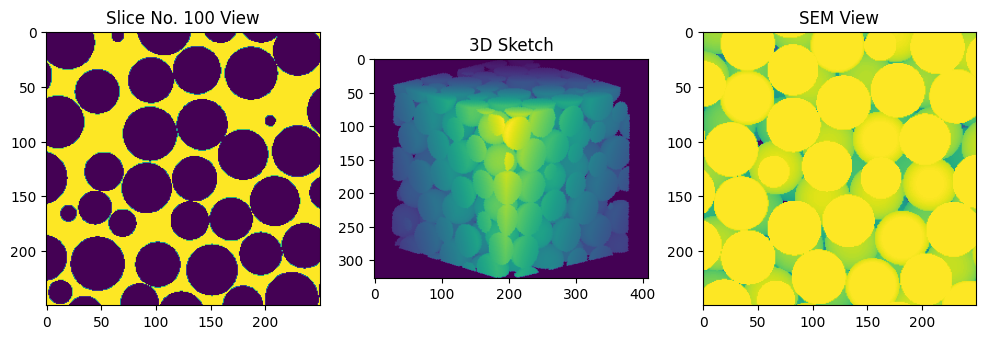

In [ ]:
# NBVAL_IGNORE_OUTPUT
fig, ax = plt.subplots(1, 3, figsize=(12,5))
ax[0].imshow(im[:, :, 100]);
ax[1].imshow(ps.visualization.show_3D(im));
ax[2].imshow(ps.visualization.sem(im));
ax[0].set_title("Slice No. 100 View");
ax[1].set_title("3D Sketch");
ax[2].set_title("SEM View");

In [40]:
settings = {'pore_shape': 'pyramid',
            'throat_shape': 'cuboid',
            
            'pore_diameter': 'equivalent_diameter',
            'throat_diameter': 'inscribed_diameter'}

  
#NBVAL_IGNORE_OUTPUT

resolution = 1e-6
snow = ps.networks.snow2(im, voxel_size=resolution,accuracy='standard')
proj= op.io.PoreSpy.import_data(snow.network, settings=settings)
net = proj[0]
geo =proj[1]

#net = op.io.network_from_porespy(snow.network)   

pn = ps.networks.label_boundaries(net,labels=[['left', 'right'], ['front', 'back'], [ 'bottom','top']], tol=1e-9)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Extracting pore and throat properties:   0%|          | 0/1205 [00:00<?, ?it/s]

In [41]:
proj= pn.project

geo['pore.area']=geo['pore.surface_area']

geo['throat.area'] =  geo['throat.cross_sectional_area']    

geo['throat.surface_area'] = geo['throat.volume']/geo['throat.equivalent_diameter']

geo['throat.conduit_lengths.pore1']= geo['throat.length']
geo['throat.conduit_lengths.pore2']= geo['throat.length']

geo.add_model(propname='throat.endpoints',
              model=mods.geometry.throat_endpoints.spherical_pores)
geo.add_model(propname='pore.area',
              model=mods.geometry.pore_cross_sectional_area.sphere)
geo.add_model(propname='pore.volume',
              model=mods.geometry.pore_volume.sphere)
geo.add_model(propname='throat.length',
              model=mods.geometry.throat_length.ctc)
geo.add_model(propname='throat.volume',
              model=mods.geometry.throat_volume.cylinder)
geo.add_model(propname='throat.area',
              model=mods.geometry.throat_cross_sectional_area.cylinder)
geo.add_model(propname='throat.surface_area',
              model=mods.geometry.throat_surface_area.cylinder)
geo.add_model(propname='throat.endpoints',
              model=mods.geometry.throat_endpoints.spherical_pores)
geo.add_model(propname='throat.conduit_lengths',
              model=mods.geometry.throat_length.conduit_lengths)

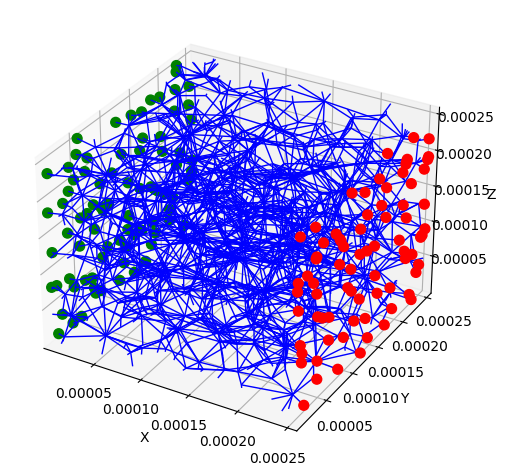

In [42]:
fig, ax = plt.subplots()
op.topotools.plot_connections(network=pn, ax=ax)
op.topotools.plot_coordinates(network=pn,
                              ax=ax,
                              pores=pn['pore.right'],
                              markersize=50, c='r');
op.topotools.plot_coordinates(network=pn,
                              ax=ax,
                              pores=pn['pore.left'],
                              markersize=50, c='g');

In [43]:
h = pn.check_network_health()
op.topotools.trim(network=pn, pores=h['trim_pores'])
h = pn.check_network_health()
print(h)

# Handle Boundary Pores - Zero Volume for saturation but not zero diam and area
# For flow calculations
geo['pore.volume'][geo['pore.area'] == 0.0] = 0
geo['pore.diameter'][geo['pore.diameter'] == 0.0] = geo['pore.diameter'].max()
geo['pore.area'][geo['pore.area'] == 0.0] = geo['pore.area'].max()

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
key                                 value
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
disconnected_clusters               []
isolated_pores                      []
trim_pores                          []
duplicate_throats                   []
bidirectional_throats               []
headless_throats                    []
looped_throats                      []
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


------------------------------------------------------------
SOURCE     : openpnm.algorithms.OrdinaryPercolation.get_intrusion_data 
TIME STAMP : 2022-11-03 15:23:55,326
------------------------------------------------------------


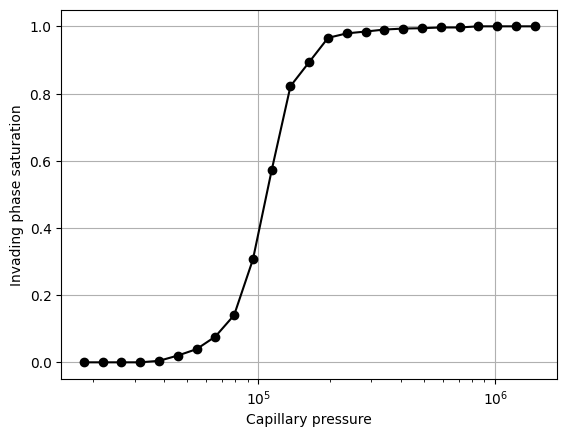

In [44]:
Hg = op.phases.Mercury(network=pn)
phys = op.physics.Standard(network=pn, phase=Hg, geometry=geo)
# Create algorithm and run simulation
mip = op.algorithms.Porosimetry(network=pn, phase=Hg)
mip.set_inlets(pores=pn.pores(['left', 'right', 'top', 'bottom']))
mip.run()
mip.plot_intrusion_curve() 

------------------------------------------------------------
SOURCE     : openpnm.algorithms.OrdinaryPercolation.get_intrusion_data 
TIME STAMP : 2022-11-03 15:23:55,629
------------------------------------------------------------


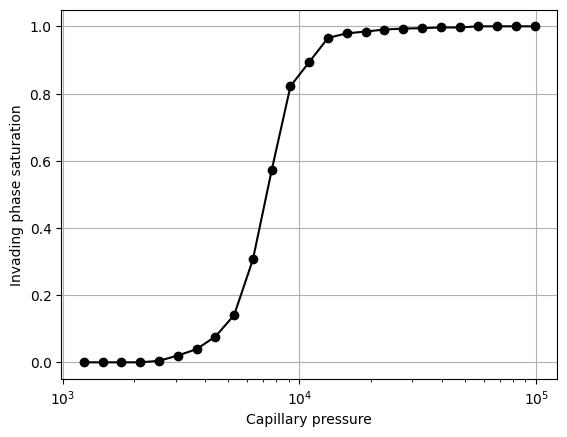

In [45]:
water = op.phases.Water(network=pn)
phys = op.physics.Standard(network=pn, phase=water, geometry=geo)
# Create algorithm and run simulation
mip = op.algorithms.Porosimetry(network=pn, phase=water)
mip.set_inlets(pores=pn.pores(['left', 'right', 'top', 'bottom']))
mip.run()
mip.plot_intrusion_curve() 

Assign phases

In [46]:
air = op.phases.Air(network=pn,name='air')
water = op.phases.Water(network = pn, name = 'water')
# Reset pore contact angle
water['pore.contact_angle'] = 110.0
#water['pore.temperature'] = 353

In [47]:
phys_air = op.physics.Standard(network=pn, phase=air, geometry=geo)
phys_water = op.physics.Standard(network=pn, phase=water, geometry=geo)
#phys_water = op.physics.Basic(network=pn, phase=water, geometry=geo)


In [48]:
OP_1 = op.algorithms.OrdinaryPercolation(network=pn)
OP_1.set_inlets(pores=pn.pores('bottom'))
OP_1.set_outlets(pores=pn.pores('top'))
OP_1.settings['trapping']=True
OP_1.setup(phase=water, pore_volume='pore.volume', throat_volume='throat.volume',access_limited=True)
OP_1.run(points=100)

In [49]:
data = OP_1.get_intrusion_data()

# Filter for evenly spaced sat inc. first and last

filter_pc = [data.Pcap[0]]
sat = [data.Snwp[0]]
for i, pc in enumerate(data.Pcap):
    if  data.Snwp[i] - sat[-1] > 0.01:
        filter_pc.append(pc)
        sat.append(data.Snwp[i])
filter_pc.append(data.Pcap[-1])
sat.append(data.Snwp[-1])


------------------------------------------------------------
SOURCE     : openpnm.algorithms.OrdinaryPercolation.get_intrusion_data 
TIME STAMP : 2022-11-03 15:23:56,094
------------------------------------------------------------


In [50]:
def update_phase_and_phys(results):
    water['pore.occupancy'] =results['pore.occupancy']
    air['pore.occupancy'] = 1-results['pore.occupancy']
    water['throat.occupancy']= results['throat.occupancy']
    air['throat.occupancy'] = 1-results['throat.occupancy']
    # Add multiphase conductances
    mode='loose'
    phys_air.add_model(model=mods.physics.multiphase.conduit_conductance,
                       propname='throat.conduit_diffusive_conductance',
                       throat_conductance='throat.diffusive_conductance',
                       mode=mode)
    phys_water.add_model(model=mods.physics.multiphase.conduit_conductance,
                         propname='throat.conduit_diffusive_conductance',
                         throat_conductance='throat.diffusive_conductance',
                         mode=mode)
    phys_air.add_model(model=mods.physics.multiphase.conduit_conductance,
                       propname='throat.conduit_hydraulic_conductance',
                       throat_conductance='throat.hydraulic_conductance',
                       mode=mode)
    phys_water.add_model(model=mods.physics.multiphase.conduit_conductance,
                         propname='throat.conduit_hydraulic_conductance',
                         throat_conductance='throat.hydraulic_conductance',
                         mode=mode)

In [51]:
update_phase_and_phys(OP_1.results(Pc=1e3))

In [52]:
atm1=0
atm2=1

In [53]:
perm_air = {'0': [], '1': [], '2': []}
diff_air = {'0': [], '1': [], '2': []}
perm_water = {'0': [], '1': [], '2': []}
diff_water = {'0': [], '1': [], '2': []}

max_Pc = max(OP_1['throat.invasion_pressure'])

num_seq = 20
pore_volumes = pn['pore.volume']
throat_volumes = pn['throat.volume']
totV = np.sum(pore_volumes) + np.sum(throat_volumes)

K_air_single_phase = [None, None, None]
D_air_single_phase = [None, None, None]
K_water_single_phase = [None, None, None]
D_water_single_phase = [None, None, None]

bounds = [['xmin', 'xmax'], ['ymin', 'ymax'], ['zmax', 'zmin']]

for bound_increment in range(len(bounds)):
    # Run Single phase algs effective properties
    BC1_pores = pn.pores(labels=bounds[bound_increment][0])
    BC2_pores = pn.pores(labels=bounds[bound_increment][1])
    
    # Effective permeability : air
    sf_air = op.algorithms.StokesFlow(network=pn, phase=air)
    sf_air.setup(conductance='throat.hydraulic_conductance')
    sf_air.set_value_BC(values=atm1, pores=BC1_pores)
    sf_air.set_value_BC(values=atm2, pores=BC2_pores)
    sf_air.run()
    K_air_single_phase[bound_increment] = sf_air.calc_effective_permeability()
    proj.purge_object(obj=sf_air)
    
    # Effective diffusivity : air
    fd_air = op.algorithms.FickianDiffusion(network=pn,phase=air)
    fd_air.setup(conductance='throat.diffusive_conductance')
    
    ## Setting Value Boundary Conditions
    fd_air.set_value_BC(values=atm1, pores=BC1_pores)
    fd_air.set_value_BC(values=atm2, pores=BC2_pores)
    fd_air.run()
    D_air_single_phase[bound_increment] = fd_air.calc_effective_diffusivity()
    proj.purge_object(obj=fd_air)
    
    # Effective permeability : water
    sf_water = op.algorithms.StokesFlow(network=pn, phase=water)
    sf_water.setup(conductance='throat.hydraulic_conductance')
    sf_water.set_value_BC(values=atm1, pores=BC1_pores)
    sf_water.set_value_BC(values=atm2, pores=BC2_pores)
    sf_water.run()
    K_water_single_phase[bound_increment] = sf_water.calc_effective_permeability()
    proj.purge_object(obj=sf_water)
    
    # Effective diffusivity : water
    fd_water = op.algorithms.FickianDiffusion(network=pn,phase=water)
    fd_water.setup(conductance='throat.diffusive_conductance')
    fd_water.set_value_BC(values=atm1, pores=BC1_pores)
    fd_water.set_value_BC(values=atm2, pores=BC2_pores)
    fd_water.run()
    D_water_single_phase[bound_increment] = fd_water.calc_effective_diffusivity()
    proj.purge_object(obj=fd_water)

------------------------------------------------------------
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_area 
TIME STAMP : 2022-11-03 15:23:56,170
------------------------------------------------------------
------------------------------------------------------------
ERROR      : Inlet and outlet faces are different area 
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_area 
TIME STAMP : 2022-11-03 15:23:56,172
------------------------------------------------------------
------------------------------------------------------------
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_length 
TIME STAMP : 2022-11-03 15:23:56,173
------------------------------------------------------------
------------------------------------------------------------
ERROR      : A unique value of length could not be found 
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_length 
TIME STAMP : 2022-11-03 15:23:56,174
---------------------------------------

In [54]:
for Pc in filter_pc:
    update_phase_and_phys(OP_1.results(Pc=Pc))
    print('-' * 80)
    print('Pc', Pc)
    for bound_increment in range(len(bounds)):
        BC1_pores = pn.pores(labels=bounds[bound_increment][0])
        BC2_pores = pn.pores(labels=bounds[bound_increment][1])

        # Multiphase
        sf_air = op.algorithms.StokesFlow(network=pn,phase=air)
        sf_air.setup(conductance='throat.conduit_hydraulic_conductance')
        sf_water = op.algorithms.StokesFlow(network=pn,phase=water)
        sf_water.setup(conductance='throat.conduit_hydraulic_conductance')

        fd_air = op.algorithms.FickianDiffusion(network=pn,phase=air)
        fd_air.setup(conductance='throat.conduit_diffusive_conductance')
        fd_water = op.algorithms.FickianDiffusion(network=pn,phase=water)
        fd_water.setup(conductance='throat.conduit_diffusive_conductance')

        #BC1
        sf_air.set_value_BC(values=atm1, pores=BC1_pores)
        sf_water.set_value_BC(values=atm1, pores=BC1_pores)
        fd_air.set_value_BC(values=atm1, pores=BC1_pores)
        fd_water.set_value_BC(values=atm1, pores=BC1_pores)

        #BC2
        sf_air.set_value_BC(values=atm2, pores=BC2_pores)
        sf_water.set_value_BC(values=atm2, pores=BC2_pores)
        fd_air.set_value_BC(values=atm2, pores=BC2_pores)
        fd_water.set_value_BC(values=atm2, pores=BC2_pores)

        # Run Multiphase algs
        sf_air.run()
        sf_water.run()
        fd_air.run()
        fd_water.run()

        Keff_air_mphase = sf_air.calc_effective_permeability()
        Deff_air_mphase = fd_air.calc_effective_diffusivity()
        Keff_water_mphase = sf_air.calc_effective_permeability()
        Deff_water_mphase = fd_water.calc_effective_diffusivity()

        Kr_eff_air = Keff_air_mphase / K_air_single_phase[bound_increment]
        Kr_eff_water = Keff_water_mphase / K_water_single_phase[bound_increment]
        Dr_eff_air = Deff_air_mphase / D_air_single_phase[bound_increment]
        Dr_eff_water = Deff_water_mphase / D_water_single_phase[bound_increment]

        perm_air[str(bound_increment)].append(Kr_eff_air)
        diff_air[str(bound_increment)].append(Dr_eff_air)
        perm_water[str(bound_increment)].append(Kr_eff_water)
        diff_water[str(bound_increment)].append(Dr_eff_water)
        
        
        proj.purge_object(obj=sf_air)
        proj.purge_object(obj=sf_water)
        proj.purge_object(obj=fd_air)
        proj.purge_object(obj=fd_water)

------------------------------------------------------------
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_area 
TIME STAMP : 2022-11-03 15:23:56,688
------------------------------------------------------------
------------------------------------------------------------
ERROR      : Inlet and outlet faces are different area 
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_area 
TIME STAMP : 2022-11-03 15:23:56,690
------------------------------------------------------------
------------------------------------------------------------
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_length 
TIME STAMP : 2022-11-03 15:23:56,690
------------------------------------------------------------
------------------------------------------------------------
ERROR      : A unique value of length could not be found 
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_length 
TIME STAMP : 2022-11-03 15:23:56,692
---------------------------------------

--------------------------------------------------------------------------------
Pc 1229.6565364540675


------------------------------------------------------------
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_area 
TIME STAMP : 2022-11-03 15:23:56,850
------------------------------------------------------------
------------------------------------------------------------
ERROR      : Inlet and outlet faces are different area 
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_area 
TIME STAMP : 2022-11-03 15:23:56,851
------------------------------------------------------------
------------------------------------------------------------
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_length 
TIME STAMP : 2022-11-03 15:23:56,852
------------------------------------------------------------
------------------------------------------------------------
ERROR      : A unique value of length could not be found 
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_length 
TIME STAMP : 2022-11-03 15:23:56,853
---------------------------------------

--------------------------------------------------------------------------------
Pc 2851.8545493120982


------------------------------------------------------------
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_area 
TIME STAMP : 2022-11-03 15:23:57,236
------------------------------------------------------------
------------------------------------------------------------
ERROR      : Inlet and outlet faces are different area 
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_area 
TIME STAMP : 2022-11-03 15:23:57,238
------------------------------------------------------------
------------------------------------------------------------
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_length 
TIME STAMP : 2022-11-03 15:23:57,238
------------------------------------------------------------
------------------------------------------------------------
ERROR      : A unique value of length could not be found 
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_length 
TIME STAMP : 2022-11-03 15:23:57,239
---------------------------------------

--------------------------------------------------------------------------------
Pc 3888.0122691134343


------------------------------------------------------------
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_area 
TIME STAMP : 2022-11-03 15:23:57,627
------------------------------------------------------------
------------------------------------------------------------
ERROR      : Inlet and outlet faces are different area 
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_area 
TIME STAMP : 2022-11-03 15:23:57,629
------------------------------------------------------------
------------------------------------------------------------
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_length 
TIME STAMP : 2022-11-03 15:23:57,629
------------------------------------------------------------
------------------------------------------------------------
ERROR      : A unique value of length could not be found 
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_length 
TIME STAMP : 2022-11-03 15:23:57,630
---------------------------------------

--------------------------------------------------------------------------------
Pc 4641.32583341502


------------------------------------------------------------
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_area 
TIME STAMP : 2022-11-03 15:23:58,060
------------------------------------------------------------
------------------------------------------------------------
ERROR      : Inlet and outlet faces are different area 
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_area 
TIME STAMP : 2022-11-03 15:23:58,061
------------------------------------------------------------
------------------------------------------------------------
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_length 
TIME STAMP : 2022-11-03 15:23:58,062
------------------------------------------------------------
------------------------------------------------------------
ERROR      : A unique value of length could not be found 
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_length 
TIME STAMP : 2022-11-03 15:23:58,063
---------------------------------------

--------------------------------------------------------------------------------
Pc 5300.634777612663


------------------------------------------------------------
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_area 
TIME STAMP : 2022-11-03 15:23:58,505
------------------------------------------------------------
------------------------------------------------------------
ERROR      : Inlet and outlet faces are different area 
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_area 
TIME STAMP : 2022-11-03 15:23:58,507
------------------------------------------------------------
------------------------------------------------------------
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_length 
TIME STAMP : 2022-11-03 15:23:58,507
------------------------------------------------------------
------------------------------------------------------------
ERROR      : A unique value of length could not be found 
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_length 
TIME STAMP : 2022-11-03 15:23:58,508
---------------------------------------

--------------------------------------------------------------------------------
Pc 5540.596068344642


------------------------------------------------------------
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_area 
TIME STAMP : 2022-11-03 15:23:58,936
------------------------------------------------------------
------------------------------------------------------------
ERROR      : Inlet and outlet faces are different area 
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_area 
TIME STAMP : 2022-11-03 15:23:58,937
------------------------------------------------------------
------------------------------------------------------------
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_length 
TIME STAMP : 2022-11-03 15:23:58,938
------------------------------------------------------------
------------------------------------------------------------
ERROR      : A unique value of length could not be found 
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_length 
TIME STAMP : 2022-11-03 15:23:58,939
---------------------------------------

--------------------------------------------------------------------------------
Pc 6053.599780337698


------------------------------------------------------------
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_area 
TIME STAMP : 2022-11-03 15:23:59,346
------------------------------------------------------------
------------------------------------------------------------
ERROR      : Inlet and outlet faces are different area 
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_area 
TIME STAMP : 2022-11-03 15:23:59,348
------------------------------------------------------------
------------------------------------------------------------
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_length 
TIME STAMP : 2022-11-03 15:23:59,348
------------------------------------------------------------
------------------------------------------------------------
ERROR      : A unique value of length could not be found 
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_length 
TIME STAMP : 2022-11-03 15:23:59,349
---------------------------------------

--------------------------------------------------------------------------------
Pc 6327.648017541263


------------------------------------------------------------
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_area 
TIME STAMP : 2022-11-03 15:23:59,729
------------------------------------------------------------
------------------------------------------------------------
ERROR      : Inlet and outlet faces are different area 
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_area 
TIME STAMP : 2022-11-03 15:23:59,730
------------------------------------------------------------
------------------------------------------------------------
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_length 
TIME STAMP : 2022-11-03 15:23:59,730
------------------------------------------------------------
------------------------------------------------------------
ERROR      : A unique value of length could not be found 
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_length 
TIME STAMP : 2022-11-03 15:23:59,732
---------------------------------------

--------------------------------------------------------------------------------
Pc 6913.524858433943


------------------------------------------------------------
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_area 
TIME STAMP : 2022-11-03 15:24:00,153
------------------------------------------------------------
------------------------------------------------------------
ERROR      : Inlet and outlet faces are different area 
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_area 
TIME STAMP : 2022-11-03 15:24:00,154
------------------------------------------------------------
------------------------------------------------------------
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_length 
TIME STAMP : 2022-11-03 15:24:00,155
------------------------------------------------------------
------------------------------------------------------------
ERROR      : A unique value of length could not be found 
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_length 
TIME STAMP : 2022-11-03 15:24:00,156
---------------------------------------

--------------------------------------------------------------------------------
Pc 7553.6480277796045


------------------------------------------------------------
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_area 
TIME STAMP : 2022-11-03 15:24:00,571
------------------------------------------------------------
------------------------------------------------------------
ERROR      : Inlet and outlet faces are different area 
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_area 
TIME STAMP : 2022-11-03 15:24:00,573
------------------------------------------------------------
------------------------------------------------------------
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_length 
TIME STAMP : 2022-11-03 15:24:00,573
------------------------------------------------------------
------------------------------------------------------------
ERROR      : A unique value of length could not be found 
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_length 
TIME STAMP : 2022-11-03 15:24:00,574
---------------------------------------

--------------------------------------------------------------------------------
Pc 7895.603889016554


------------------------------------------------------------
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_area 
TIME STAMP : 2022-11-03 15:24:01,023
------------------------------------------------------------
------------------------------------------------------------
ERROR      : Inlet and outlet faces are different area 
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_area 
TIME STAMP : 2022-11-03 15:24:01,025
------------------------------------------------------------
------------------------------------------------------------
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_length 
TIME STAMP : 2022-11-03 15:24:01,025
------------------------------------------------------------
------------------------------------------------------------
ERROR      : A unique value of length could not be found 
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_length 
TIME STAMP : 2022-11-03 15:24:01,027
---------------------------------------

--------------------------------------------------------------------------------
Pc 8253.040192366276


------------------------------------------------------------
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_area 
TIME STAMP : 2022-11-03 15:24:01,470
------------------------------------------------------------
------------------------------------------------------------
ERROR      : Inlet and outlet faces are different area 
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_area 
TIME STAMP : 2022-11-03 15:24:01,472
------------------------------------------------------------
------------------------------------------------------------
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_length 
TIME STAMP : 2022-11-03 15:24:01,472
------------------------------------------------------------
------------------------------------------------------------
ERROR      : A unique value of length could not be found 
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_length 
TIME STAMP : 2022-11-03 15:24:01,473
---------------------------------------

--------------------------------------------------------------------------------
Pc 8626.657741982666


------------------------------------------------------------
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_area 
TIME STAMP : 2022-11-03 15:24:01,879
------------------------------------------------------------
------------------------------------------------------------
ERROR      : Inlet and outlet faces are different area 
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_area 
TIME STAMP : 2022-11-03 15:24:01,880
------------------------------------------------------------
------------------------------------------------------------
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_length 
TIME STAMP : 2022-11-03 15:24:01,881
------------------------------------------------------------
------------------------------------------------------------
ERROR      : A unique value of length could not be found 
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_length 
TIME STAMP : 2022-11-03 15:24:01,882
---------------------------------------

--------------------------------------------------------------------------------
Pc 9017.189067629208


------------------------------------------------------------
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_area 
TIME STAMP : 2022-11-03 15:24:02,286
------------------------------------------------------------
------------------------------------------------------------
ERROR      : Inlet and outlet faces are different area 
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_area 
TIME STAMP : 2022-11-03 15:24:02,288
------------------------------------------------------------
------------------------------------------------------------
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_length 
TIME STAMP : 2022-11-03 15:24:02,288
------------------------------------------------------------
------------------------------------------------------------
ERROR      : A unique value of length could not be found 
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_length 
TIME STAMP : 2022-11-03 15:24:02,290
---------------------------------------

--------------------------------------------------------------------------------
Pc 9425.399860906515


------------------------------------------------------------
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_area 
TIME STAMP : 2022-11-03 15:24:02,735
------------------------------------------------------------
------------------------------------------------------------
ERROR      : Inlet and outlet faces are different area 
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_area 
TIME STAMP : 2022-11-03 15:24:02,736
------------------------------------------------------------
------------------------------------------------------------
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_length 
TIME STAMP : 2022-11-03 15:24:02,736
------------------------------------------------------------
------------------------------------------------------------
ERROR      : A unique value of length could not be found 
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_length 
TIME STAMP : 2022-11-03 15:24:02,737
---------------------------------------

--------------------------------------------------------------------------------
Pc 9852.09047649857


------------------------------------------------------------
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_area 
TIME STAMP : 2022-11-03 15:24:03,138
------------------------------------------------------------
------------------------------------------------------------
ERROR      : Inlet and outlet faces are different area 
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_area 
TIME STAMP : 2022-11-03 15:24:03,139
------------------------------------------------------------
------------------------------------------------------------
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_length 
TIME STAMP : 2022-11-03 15:24:03,140
------------------------------------------------------------
------------------------------------------------------------
ERROR      : A unique value of length could not be found 
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_length 
TIME STAMP : 2022-11-03 15:24:03,141
---------------------------------------

--------------------------------------------------------------------------------
Pc 10298.097501380511


------------------------------------------------------------
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_area 
TIME STAMP : 2022-11-03 15:24:03,566
------------------------------------------------------------
------------------------------------------------------------
ERROR      : Inlet and outlet faces are different area 
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_area 
TIME STAMP : 2022-11-03 15:24:03,568
------------------------------------------------------------
------------------------------------------------------------
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_length 
TIME STAMP : 2022-11-03 15:24:03,568
------------------------------------------------------------
------------------------------------------------------------
ERROR      : A unique value of length could not be found 
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_length 
TIME STAMP : 2022-11-03 15:24:03,570
---------------------------------------

--------------------------------------------------------------------------------
Pc 10764.29539506525


------------------------------------------------------------
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_area 
TIME STAMP : 2022-11-03 15:24:04,025
------------------------------------------------------------
------------------------------------------------------------
ERROR      : Inlet and outlet faces are different area 
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_area 
TIME STAMP : 2022-11-03 15:24:04,026
------------------------------------------------------------
------------------------------------------------------------
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_length 
TIME STAMP : 2022-11-03 15:24:04,027
------------------------------------------------------------
------------------------------------------------------------
ERROR      : A unique value of length could not be found 
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_length 
TIME STAMP : 2022-11-03 15:24:04,028
---------------------------------------

--------------------------------------------------------------------------------
Pc 11760.961354204204


------------------------------------------------------------
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_area 
TIME STAMP : 2022-11-03 15:24:04,428
------------------------------------------------------------
------------------------------------------------------------
ERROR      : Inlet and outlet faces are different area 
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_area 
TIME STAMP : 2022-11-03 15:24:04,430
------------------------------------------------------------
------------------------------------------------------------
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_length 
TIME STAMP : 2022-11-03 15:24:04,430
------------------------------------------------------------
------------------------------------------------------------
ERROR      : A unique value of length could not be found 
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_length 
TIME STAMP : 2022-11-03 15:24:04,431
---------------------------------------

--------------------------------------------------------------------------------
Pc 12293.383523474045


------------------------------------------------------------
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_area 
TIME STAMP : 2022-11-03 15:24:04,804
------------------------------------------------------------
------------------------------------------------------------
ERROR      : Inlet and outlet faces are different area 
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_area 
TIME STAMP : 2022-11-03 15:24:04,805
------------------------------------------------------------
------------------------------------------------------------
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_length 
TIME STAMP : 2022-11-03 15:24:04,806
------------------------------------------------------------
------------------------------------------------------------
ERROR      : A unique value of length could not be found 
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_length 
TIME STAMP : 2022-11-03 15:24:04,807
---------------------------------------

--------------------------------------------------------------------------------
Pc 12849.908600473364


------------------------------------------------------------
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_area 
TIME STAMP : 2022-11-03 15:24:05,226
------------------------------------------------------------
------------------------------------------------------------
ERROR      : Inlet and outlet faces are different area 
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_area 
TIME STAMP : 2022-11-03 15:24:05,228
------------------------------------------------------------
------------------------------------------------------------
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_length 
TIME STAMP : 2022-11-03 15:24:05,228
------------------------------------------------------------
------------------------------------------------------------
ERROR      : A unique value of length could not be found 
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_length 
TIME STAMP : 2022-11-03 15:24:05,229
---------------------------------------

--------------------------------------------------------------------------------
Pc 13431.627730902916


------------------------------------------------------------
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_area 
TIME STAMP : 2022-11-03 15:24:05,631
------------------------------------------------------------
------------------------------------------------------------
ERROR      : Inlet and outlet faces are different area 
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_area 
TIME STAMP : 2022-11-03 15:24:05,633
------------------------------------------------------------
------------------------------------------------------------
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_length 
TIME STAMP : 2022-11-03 15:24:05,633
------------------------------------------------------------
------------------------------------------------------------
ERROR      : A unique value of length could not be found 
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_length 
TIME STAMP : 2022-11-03 15:24:05,634
---------------------------------------

--------------------------------------------------------------------------------
Pc 14675.261953478668


------------------------------------------------------------
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_area 
TIME STAMP : 2022-11-03 15:24:06,039
------------------------------------------------------------
------------------------------------------------------------
ERROR      : Inlet and outlet faces are different area 
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_area 
TIME STAMP : 2022-11-03 15:24:06,041
------------------------------------------------------------
------------------------------------------------------------
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_length 
TIME STAMP : 2022-11-03 15:24:06,041
------------------------------------------------------------
------------------------------------------------------------
ERROR      : A unique value of length could not be found 
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_length 
TIME STAMP : 2022-11-03 15:24:06,042
---------------------------------------

--------------------------------------------------------------------------------
Pc 22849.249536507767


------------------------------------------------------------
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_area 
TIME STAMP : 2022-11-03 15:24:06,436
------------------------------------------------------------
------------------------------------------------------------
ERROR      : Inlet and outlet faces are different area 
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_area 
TIME STAMP : 2022-11-03 15:24:06,437
------------------------------------------------------------
------------------------------------------------------------
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_length 
TIME STAMP : 2022-11-03 15:24:06,438
------------------------------------------------------------
------------------------------------------------------------
ERROR      : A unique value of length could not be found 
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_length 
TIME STAMP : 2022-11-03 15:24:06,439
---------------------------------------

--------------------------------------------------------------------------------
Pc 98495.41164138497


------------------------------------------------------------
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_area 
TIME STAMP : 2022-11-03 15:24:06,840
------------------------------------------------------------
------------------------------------------------------------
ERROR      : Inlet and outlet faces are different area 
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_area 
TIME STAMP : 2022-11-03 15:24:06,842
------------------------------------------------------------
------------------------------------------------------------
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_length 
TIME STAMP : 2022-11-03 15:24:06,842
------------------------------------------------------------
------------------------------------------------------------
ERROR      : A unique value of length could not be found 
SOURCE     : openpnm.algorithms.GenericTransport._get_domain_length 
TIME STAMP : 2022-11-03 15:24:06,843
---------------------------------------

[1.     0.9873 0.9761 0.9586 0.942  0.9182 0.8998 0.8565 0.8228 0.6638
 0.5012 0.4542 0.3653 0.3126 0.2468 0.1514 0.1406 0.1175 0.0819 0.0572
 0.045  0.0349 0.0232 0.0097 0.    ]
[array([1.]), array([0.9918]), array([0.9848]), array([0.9799]), array([0.967]), array([0.9235]), array([0.8967]), array([0.8433]), array([0.7871]), array([0.5523]), array([0.3664]), array([0.2671]), array([0.1779]), array([0.155]), array([0.1223]), array([0.0551]), array([0.0436]), array([0.0268]), array([0.0084]), array([0.0026]), array([0.0019]), array([0.0011]), array([0.0003]), array([5.7776e-05]), array([1.e-06])]


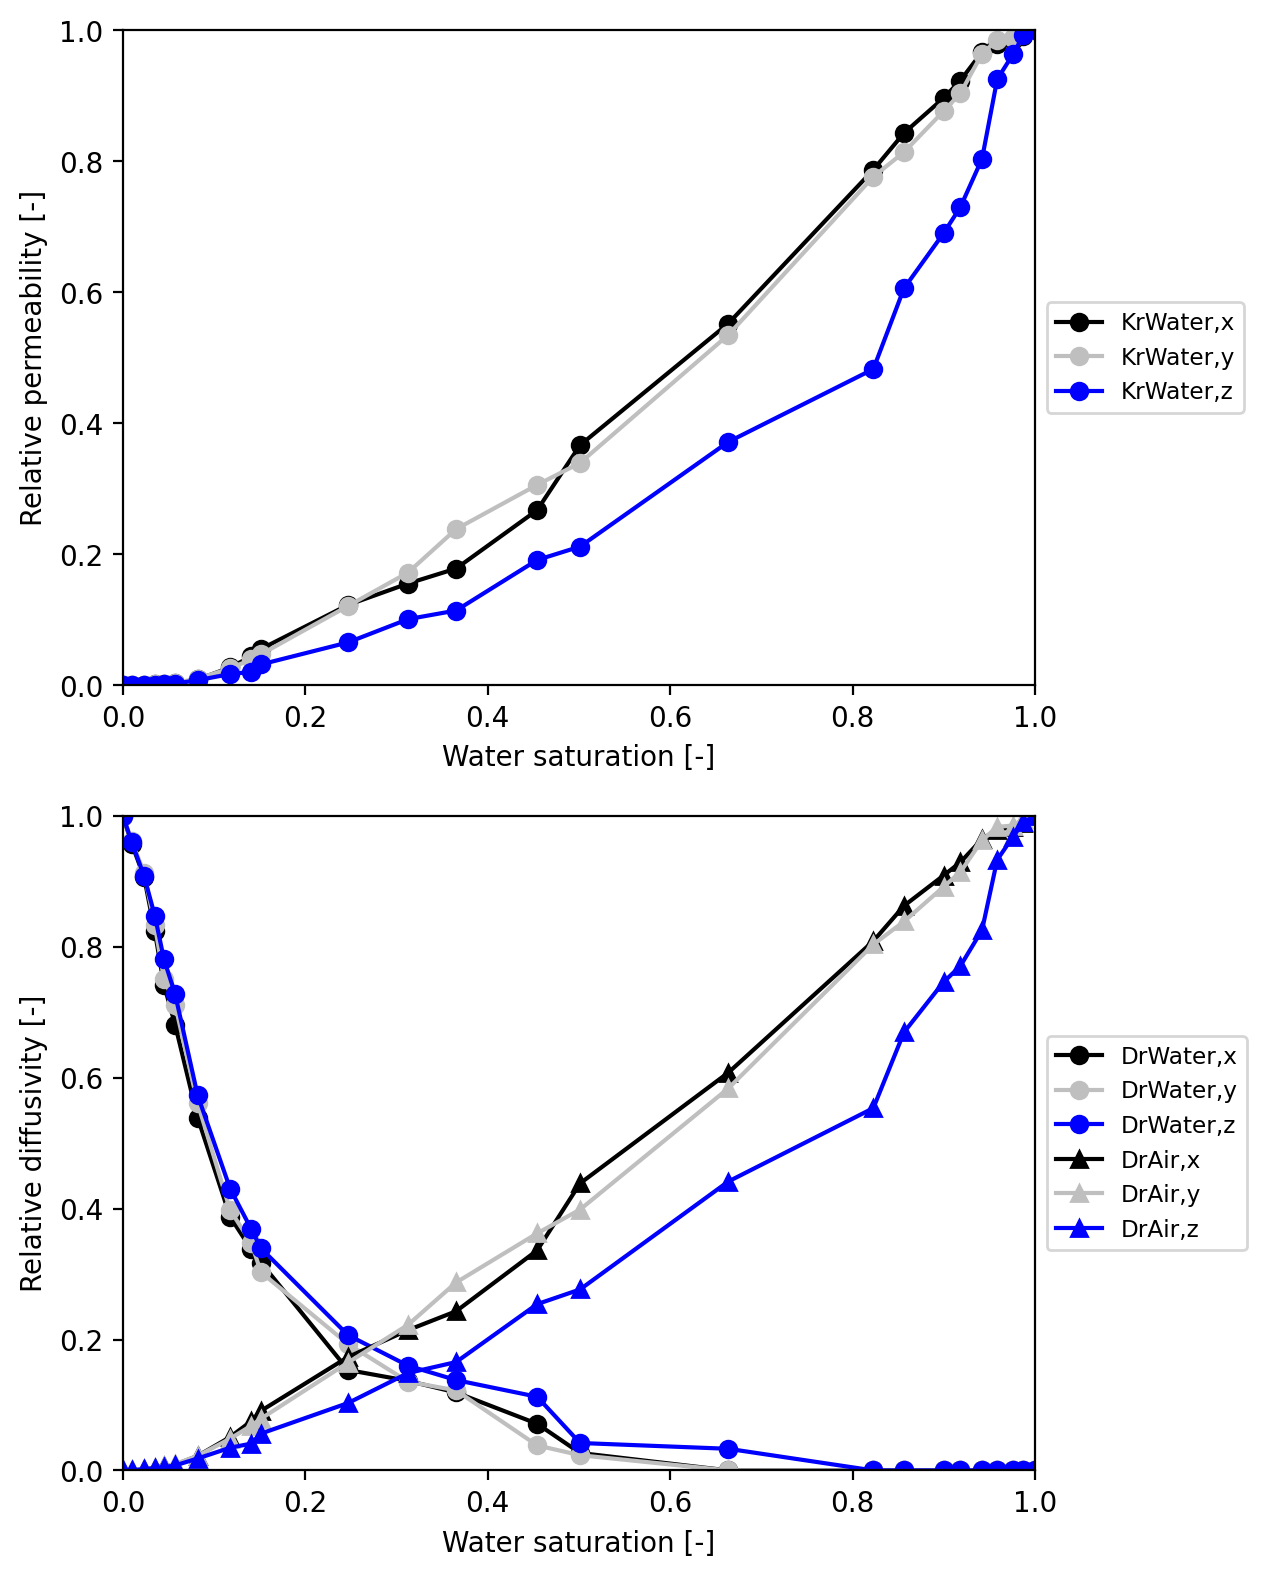

In [58]:
from matplotlib.font_manager import FontProperties
%matplotlib inline
print(sat)
print(perm_water['0'][:])

#sat = 1-np.asarray(sat)

fontP = FontProperties()
fontP.set_size('small')
# Setting up subplots
fig = plt.figure(figsize=(8, 8), dpi=200, facecolor='w', edgecolor='k')
ax1 = fig.add_subplot(211)   #top
ax2 = fig.add_subplot(212)   #bottom

x_values1 = [x/20 for x in range(21)]
z = '.75'
perm_water['0'] = perm_water['0']
# Plots for subplot1 - strict permeability
p1, = ax1.plot(sat, perm_water['0'], color = 'k', linestyle = '-', marker = 'o')
p2, = ax1.plot(sat, perm_water['1'], color = z, linestyle = '-', marker = 'o')
p3, = ax1.plot(sat, perm_water['2'], color = 'b', linestyle = '-', marker = 'o')
#p4, = ax1.plot(sat, perm_air['0'], color = 'k', linestyle = '-', marker = '^')
#p5, = ax1.plot(sat, perm_air['1'], color = z, linestyle = '-', marker = '^')
#p6, = ax1.plot(sat, perm_air['2'], color = 'b', linestyle = '-', marker = '^')
#p10, = ax1.plot(x_values1, [x**(3) for x in x_values1], 'k--')
#ax1.plot(x_values1, [(1-x)**(3) for x in x_values1], 'k--')
#gs1, = ax1.plot(gostick_saturation_1, gostick_perm_air_case1, color = 'r', linestyle = '-', marker = 'D')
#gs2, = ax1.plot(gostick_saturation_2, gostick_perm_water, color = 'r', linestyle = '-', marker = 'o')
ax1.set_ylabel('Relative permeability [-]')
ax1.set_xlabel("Water saturation [-]")
ax1.set_ylim([0,1])
ax1.set_xlim([0,1])

# Need to work on legend to match up with the right things
lgd1 = ax1.legend([p1, p2, p3, p4, p5, p6, p10, 
                   # gs1, gs2
                  ],
                  ["KrWater,x", "KrWater,y", "KrWater,z",
                  # "KrAir,x","KrAir,y","KrAir,z", "a = 3"
                   #"Gostick et al \n KrAir,x (case 1)", 
                   #"Gostick et al \n KrWater,x"
                   ], 
                  loc='center left', bbox_to_anchor=(1, 0.5), prop=fontP)

#sat = 1-np.asarray(sat)
# Plots for subplot4 - diffusivity
p11, = ax2.plot(sat, diff_water['0'], color = 'k', linestyle = '-', marker = 'o')
p12, = ax2.plot(sat, diff_water['1'], color = z, linestyle = '-', marker = 'o')
p13, = ax2.plot(sat, diff_water['2'], color = 'b', linestyle = '-', marker = 'o')
p14, = ax2.plot(sat, diff_air['0'], color = 'k', linestyle = '-', marker = '^')
p15, = ax2.plot(sat, diff_air['1'], color = z, linestyle = '-', marker = '^')
p16, = ax2.plot(sat, diff_air['2'], color = 'b', linestyle = '-', marker = '^')
#p20, = ax2.plot(x_values1, [x**(2) for x in x_values1], 'k--')
#ax2.plot(x_values1, [(1-x)**(2) for x in x_values1], 'k--')
#gs3, = ax2.plot(gostick_saturation_3, gostick_diff_air_case1, color = 'r', linestyle = '-', marker = 'D')
#gs4, = ax2.plot(gostick_saturation_4, gostick_diff_water, color = 'r', linestyle = '-', marker = 'o')
ax2.set_ylabel('Relative diffusivity [-]')
ax2.set_xlabel("Water saturation [-]")
ax2.set_ylim([0,1])
ax2.set_xlim([0,1])

lgd2 = ax2.legend([p11, p12, p13, p14, p15, p16, p20,
                   # gs3, gs4
                    ],
                  ["DrWater,x", "DrWater,y", "DrWater,z",
                   "DrAir,x","DrAir,y","DrAir,z", 
                   #"a = 2",
                  # "Gostick et al \n DrAir,x (case 1)", 
                  # "Gostick et al \n DrWater,x"], 
                   ], 
                  loc='center left', bbox_to_anchor=(1, 0.5), prop=fontP)

fig.subplots_adjust(left=0.13, right=.7, top=0.95, bottom=0.05)

plt.show()